## GaussianNB and Missing values 

In [1]:
# the usual setup: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load training data
df = pd.read_csv('data/atlas-higgs-challenge-2014-v2.csv.gz')
# map y values to integers
df['Label'] = df['Label'].map({'b':0, 's':1});

In [3]:
# let's create separate arrays for ML models
eventID = df['EventId']
X = df.loc[:,'DER_mass_MMC':'PRI_jet_all_pt']
y = df['Label']
weight = df['Weight']

In [4]:
# now split data and weights into testing and training samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, eventID_train, event_ID_test, weight_train, weight_test = train_test_split(
    X, y, eventID, weight, test_size=0.33, random_state=42)

### GaussianNB

Naive Bayes classifiers are built on Bayesian classification methods.
Use Bayes’s theorem:
$$P(B|A)P(A) = P(A|B)P(B)$$
to write
$$
P(L|\text{features}) = \frac{ P(\text{features}|L) P(L) }{ P(\text{features}) }
$$
and from this to compute the ratio of the probability of two labels of a sample given the features:
$$
\frac{ P(L_1|\text{features}) }{ P(L_2|\text{features}) } = \frac{ P(\text{features}|L_1)P(L_1) }{ P(\text{features}|L_2)P(L_2) }
$$
(Note that $P(\text{features})$ cancels out.)

In the Gaussian Naive Bayes classifier, the assumption is that data from each label is drawn from a simple Gaussian distribution.

In [5]:
# GaussianNB (Gaussian Naive Bayes, assumes each class is drawn from an axis-aligned Gaussian distribution)
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(X_train, y_train);             # 3. fit model to data

In [6]:
model.score(X_test, y_test)

0.6783633744292068

In [7]:
# define function to plot probability for sig/bg
def plot_proba( df, model, x ):
    df['Prob']=model.predict_proba(x)[:, 1]
    kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40, density=True)
    df[df.Label==0].Prob.hist(label='Background',**kwargs)
    df[df.Label==1].Prob.hist(label='Signal',**kwargs)
    _=plt.legend()

0.6783633744292068


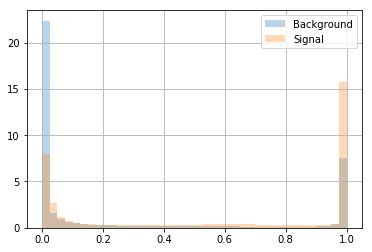

In [8]:
plot_proba(df, model, X)
print(model.score(X_test, y_test))

In [9]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, model.predict(X_test))

array([[131791,  45854],
       [ 40994,  51380]])

In [10]:
modelpars0 = pd.DataFrame({"mean": model.theta_[0,:], "sigma": np.sqrt(model.sigma_[0,:])}, index = X.keys())
modelpars1 = pd.DataFrame({"mean": model.theta_[1,:], "sigma": np.sqrt(model.sigma_[1,:])}, index = X.keys())

We can visualize the fits done by GaussianNB:

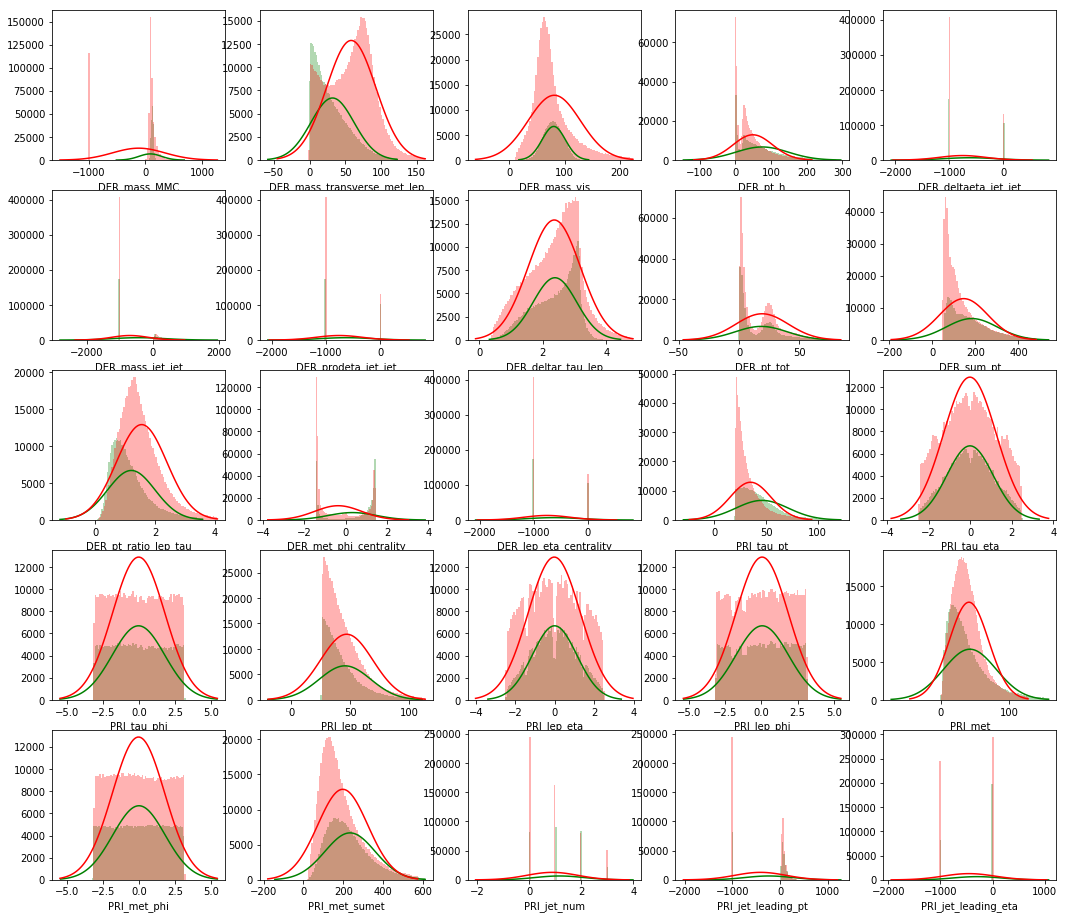

In [11]:
import scipy.stats as stats

def plot(featurepars, data, color):
    xmin = featurepars["mean"] - 3*featurepars["sigma"]
    xmax = featurepars["mean"] + 3*featurepars["sigma"]
    ax.hist(data, bins = 100, range = (xmin, xmax), color = color, alpha = 0.3);
    x = np.linspace(xmin, xmax, 100)
    ax.plot(x, 
            stats.norm.pdf(x, featurepars["mean"], featurepars["sigma"])*len(data)/100*(xmax - xmin), 
            color = color)
    
fig, axes = plt.subplots(5, 5, figsize=(18, 16))
for idx, ax in enumerate(axes.ravel()):
    var = X.keys()[idx]
    ax.set_xlabel(var)
    # plot signal
    plot(modelpars1.loc[var], X[y == 1][var], "g")
    # plot background
    plot(modelpars0.loc[var], X[y == 0][var], "r")


### Replace missing values

In [12]:
# (re-)compute cross-validation score on original model
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), X, y).mean()

/home/alex/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6775559197596034

In [13]:
# replace placeholder values (-999.)
#X = X.where(X != -999, np.nan) # -999 -> NaN
from sklearn.impute import SimpleImputer
for strategy in ["constant", "mean", "median", "most_frequent"]:
    imp = SimpleImputer(missing_values = -999, strategy = strategy)
    X2 = imp.fit_transform(X)
    # retrain model and determine score (should slightly improve)
    print "Strategy", strategy, "yields a score of", cross_val_score(GaussianNB(), X2, y).mean()

Strategy constant yields a score of 0.6839587006796704
Strategy mean yields a score of 0.6866645163546578
Strategy median yields a score of 0.6895842045701045
Strategy most_frequent yields a score of 0.6836812756480498
